<a href="https://colab.research.google.com/github/ofoeduchisom/movie-data-pipeline-analysis/blob/main/big_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas matplotlib seaborn
!pip install -q gdown

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

^C

gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [3]:
import gdown
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [7]:
# Google Drive file ID of the dataset
file_id = "10LhIqJ-Dh4X9BNyOlY1g6xu62q3X0eRo"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "merged_data.csv", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=10LhIqJ-Dh4X9BNyOlY1g6xu62q3X0eRo
From (redirected): https://drive.google.com/uc?id=10LhIqJ-Dh4X9BNyOlY1g6xu62q3X0eRo&confirm=t&uuid=784e674a-f68b-4042-b36f-ca7db959b05a
To: /content/merged_data.csv
100%|██████████| 954M/954M [00:09<00:00, 103MB/s] 


'merged_data.csv'

In [8]:
df = pd.read_csv("merged_data.csv")

<ipython-input-8-5bb80ff080e2>:1: DtypeWarning: Columns (7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("merged_data.csv")


In [6]:
# Displays Number of columns in dataframe
len(df.columns)

12

In [ ]:
# Displays Number of rows in the dataframe
df.count()

12077679

In [ ]:
def drop_duplicates_tconst(df):
    # Remove duplicates and sort by 'tconst'
    return df.dropDuplicates(["tconst"]).orderBy("tconst", ascending=True)
#Update the DataFrame
df = drop_duplicates_tconst(df)

In [ ]:
df.show()

+---------+---------+---------+--------------+--------------------+-------------+--------+---------+---------------+------+-----------+---------------+
|   tconst|titleType|startYear|runtimeMinutes|              genres|averageRating|numVotes|   nconst|       category|Region|      Types|isOriginalTitle|
+---------+---------+---------+--------------+--------------------+-------------+--------+---------+---------------+------+-----------+---------------+
|tt0000001|    short|     1894|             1|   Documentary,Short|          5.7|    2100|nm0005690|       director|    DE|         \N|              0|
|tt0000002|    short|     1892|             5|     Animation,Short|          5.6|     282|nm0721526|       director|    HU|imdbDisplay|              0|
|tt0000003|    short|     1892|             5|Animation,Comedy,...|          6.5|    2119|nm0721526|       director|    DE|         \N|              0|
|tt0000004|    short|     1892|            12|     Animation,Short|          5.4|     18

In [ ]:
#number of rows after dropping duplicates
df.count()

1048575

In [ ]:
from pyspark.sql.functions import col, sum, when

In [ ]:
def replace_null_strings(df):
    # Replace '\\N' with None in all columns
    return df.select([when(col(c) == '\\N', None).otherwise(col(c)).alias(c) for c in df.columns])
# Update the DataFrame
df = replace_null_strings(df)

In [ ]:
df.show()

+---------+---------+---------+--------------+--------------------+-------------+--------+---------+---------------+------+-----------+---------------+
|   tconst|titleType|startYear|runtimeMinutes|              genres|averageRating|numVotes|   nconst|       category|Region|      Types|isOriginalTitle|
+---------+---------+---------+--------------+--------------------+-------------+--------+---------+---------------+------+-----------+---------------+
|tt0000001|    short|     1894|             1|   Documentary,Short|          5.7|    2100|nm0005690|       director|    DE|       NULL|              0|
|tt0000002|    short|     1892|             5|     Animation,Short|          5.6|     282|nm0721526|       director|    HU|imdbDisplay|              0|
|tt0000003|    short|     1892|             5|Animation,Comedy,...|          6.5|    2119|nm0721526|       director|    DE|       NULL|              0|
|tt0000004|    short|     1892|            12|     Animation,Short|          5.4|     18

In [ ]:
def drop_null_rows(df):
    # Drop rows with any null values
    return df.dropna()
# Update the DataFrame
df = drop_null_rows(df)

In [ ]:
df.show()

In [ ]:
def drop_column(df, isOriginalTitle):
    # Drop the specified column from the DataFrame
    return df.drop(isOriginalTitle)
# Update the DataFrame by dropping the 'isOriginalTitle' column
df = drop_column(df, "isOriginalTitle")

In [ ]:
df.show()

In [ ]:
#Get the list of columns in the DataFrame
df.columns

['tconst',
 'titleType',
 'startYear',
 'runtimeMinutes',
 'genres',
 'averageRating',
 'numVotes',
 'nconst',
 'category',
 'Region',
 'Types']

In [ ]:
# Get data types for each column
df.dtypes

[('tconst', 'string'),
 ('titleType', 'string'),
 ('startYear', 'int'),
 ('runtimeMinutes', 'string'),
 ('genres', 'string'),
 ('averageRating', 'double'),
 ('numVotes', 'int'),
 ('nconst', 'string'),
 ('category', 'string'),
 ('Region', 'string'),
 ('Types', 'string')]

In [ ]:
# Import the col function for column operations
from pyspark.sql.functions import col

# Function to cast the data types of specified columns in a DataFrame
def cast_columns(df, columns_to_cast):
    # Iterate through the dictionary of columns to cast
    for column, dtype in columns_to_cast.items():
        # Update the DataFrame by casting each column to the specified data type
        df = df.withColumn(column, col(column).cast(dtype))
    return df
columns_to_cast = {
    "runtimeMinutes": "int"
}
# Call the cast_columns function to apply the type casting to the DataFrame
df = cast_columns(df, columns_to_cast)
# print schema
df.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- startYear: integer (nullable = true)
 |-- runtimeMinutes: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)
 |-- nconst: string (nullable = true)
 |-- category: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Types: string (nullable = true)



In [ ]:
# Get the total number of rows in the DataFrame
df.count()

38323

In [ ]:
# Function to Display distinct values in region column
def check_for_distinct_values(df, Region):

# display disinct values
  return df.select(Region).distinct().show()

# Call the function to check for distinct values in the 'Region' column
check_for_distinct_values(df, "Region")

+------+
|Region|
+------+
|    LT|
|    DZ|
|    FI|
|    UA|
|    RO|
|    NL|
|  DDDE|
|  VDVN|
|    PL|
|    MX|
|    EE|
|    AT|
|    RU|
|    HR|
|    SV|
|    CZ|
|    PT|
|    HK|
|    TW|
|    CL|
+------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import length
# Function to remove rows where the 'Region' column has more than two characters
def remove_rows_with_more_than_two_characters(df, Region):
     # Remove rows where the length of the 'Region' column is greater than 2
    df_cleaned = df.filter(~(length(df[Region]) > 2))
    return df_cleaned
# Apply the function to clean the DataFrame
df = remove_rows_with_more_than_two_characters(df, 'Region')

In [ ]:
df.select("Region").distinct().show()

+------+
|Region|
+------+
|    LT|
|    DZ|
|    FI|
|    UA|
|    RO|
|    NL|
|    PL|
|    MX|
|    EE|
|    AT|
|    RU|
|    HR|
|    SV|
|    CZ|
|    PT|
|    HK|
|    TW|
|    CL|
|    ID|
|    AU|
+------+
only showing top 20 rows



In [ ]:
# Function to Display distinct values in types column
def check_for_distinct_values(df, Types):

# display disinct values
  return df.select(Types).distinct().show()

# Call the function to check for distinct values in the 'Types' column
check_for_distinct_values(df, "Types")

+--------------+
|         Types|
+--------------+
|   imdbDisplay|
|   alternative|
|            tv|
|           dvd|
|      festival|
|         video|
|       working|
|imdbDisplaytv|
+--------------+



In [ ]:
from pyspark.sql.functions import col

def remove_rows_with_non_printable(df, column_name):
     # Check if the specified column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")

    # Filter out rows with non-printable characters in the specified column
    df_cleaned = df.filter(~col(column_name).rlike(r'[\x00-\x1F\x7F\x80-\x9F]'))
    return df_cleaned

# Apply the function to clean the DataFrame
df = remove_rows_with_non_printable(df, 'Types')

In [ ]:
# Function to Display distinct values in types column
def check_for_distinct_values(df, Types):

# display disinct values
  return df.select(Types).distinct().show()

# Call the function to check for distinct values in the 'Types' column
check_for_distinct_values(df, "Types")

+-----------+
|      Types|
+-----------+
|imdbDisplay|
|alternative|
|         tv|
|        dvd|
|   festival|
|      video|
|    working|
+-----------+



In [ ]:
df.count()

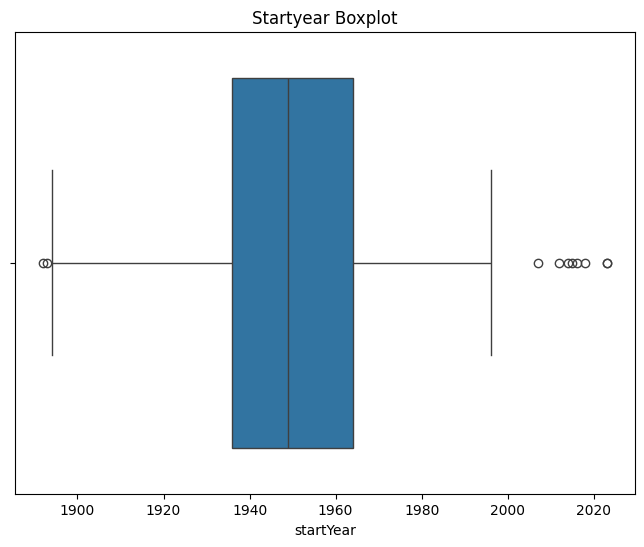

In [ ]:
#Function to check for outliers in a column using boxplot
def plot_boxplot_of_startyear(df):
    # Convert the 'startyear' column from PySpark DataFrame to Pandas DataFrame
    pandas_df = df.select('startYear').toPandas()

    # Create a boxplot for the 'startyear' column
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=pandas_df['startYear'])
    plt.title('Startyear Boxplot')
    plt.show()

plot_boxplot_of_startyear(df)

In [ ]:
# Calculate the first quartile (Q1), third quartile (Q3), and interquartile range (IQR) for a specified column.
def calculate_Q1_Q3(df, column_name):
    # Calculate the first quartile (Q1)
    q1 = df.approxQuantile(column_name, [0.25], 0.0)[0]

    # Calculate the third quartile (Q1)
    q3 = df.approxQuantile(column_name, [0.75], 0.0)[0]

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1
    return q1, q3, iqr

# Calculate Q1, Q3, and IQR for the 'startYear' column
q1, q3, iqr = calculate_Q1_Q3(df, 'startYear')

# Calculate the lower and upper bounds for outlier detection
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [ ]:
# Import functions from pyspark.sql module
from pyspark.sql import functions as F

# Define a function to calculate the median value of a specified column in a DataFrame
def calculate_median_value(df, column_name):

    # Use the percentile_approx function to calculate the approximate median (50th percentile) of the column
    median_value = df.select(F.percentile_approx(column_name, 0.5)).first()[0]

    # Return the calculated median value
    return median_value

# Call the function with a DataFrame 'df' and the column 'startYear' to calculate the median
print(calculate_median_value(df, 'startYear'))

1949


In [ ]:
# Calculate the median value of the 'startYear' column
median_value = calculate_median_value(df, 'startYear')

# Replace out-of-bounds values in the 'startYear' column with the calculated median
df = df.withColumn(
    "startYear",
     # Use the 'when' condition to check if values are out of bounds otherwise keep the original value
    F.when((df["startYear"] < lower_bound) | (df["startYear"] > upper_bound), median_value)
     .otherwise(df["startYear"])
)

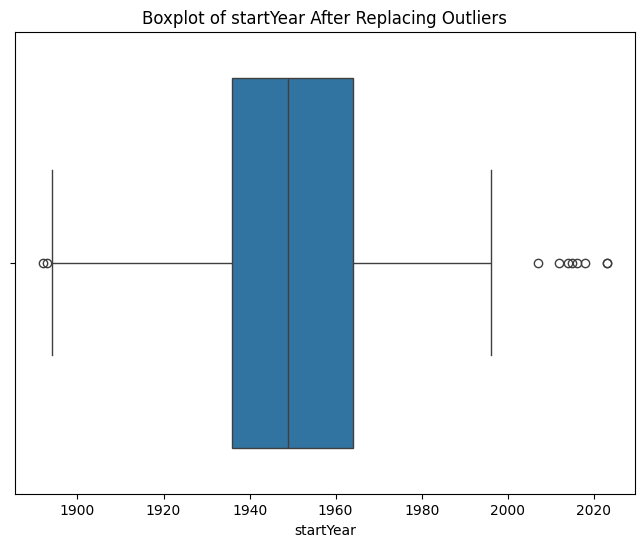

In [ ]:
# Function to generate a boxplot for the 'startYear' column
def startYear_boxplot(df):

  # Convert the 'startYear' column from Spark DataFrame to a Pandas DataFrame
    pandas_df = df.select('startYear').toPandas()

# Create the boxplot
    plt.figure(figsize=(8, 6)) # Set the figure size for better visualization
    sns.boxplot(x=pandas_df['startYear']) # Create a boxplot of the 'averagestartYearRating' values
    plt.title('Boxplot of startYear After Replacing Outliers') # Set the title for the plot
    plt.show() # Display the plot

# Call the function to generate the boxplot for 'averageRating'
startYear_boxplot(df)

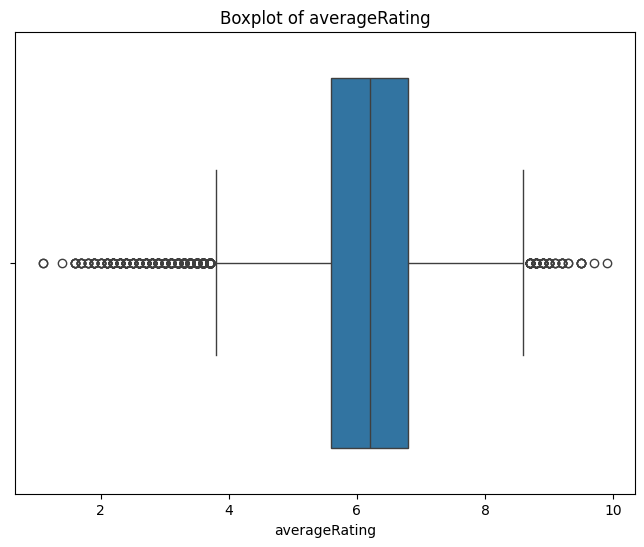

In [ ]:
# Function to generate a boxplot for the 'averageRating' column
def averageRating_boxplot(df):
      # Convert the 'averageRating' column from PySpark DataFrame to Pandas DataFrame
    pandas_df = df.select('averageRating').toPandas()

    # create boxplot
    plt.figure(figsize=(8, 6)) # Set the figure size for better visualization
    sns.boxplot(x=pandas_df['averageRating'])  # Create a boxplot of the 'averageRating' values
    plt.title('Boxplot of averageRating')  # Set the title for the plot
    plt.show() # Display the plot

# Call the function to generate the boxplot for 'averageRating'
averageRating_boxplot(df)

In [ ]:
# Function to calculate the first quartile (Q1), third quartile (Q3), and interquartile range (IQR) for a specified column
def calculate_Q1_Q3(df, column_name):

    # Calculate the first quartile (Q1) using approxQuantile function. 0.25 represents the 25th percentile (Q1)
    q1 = df.approxQuantile(column_name, [0.25], 0.0)[0]

    # Calculate the third quartile (Q3) using approxQuantile function. 0.75 represents the 75th percentile (Q3)
    q3 = df.approxQuantile(column_name, [0.75], 0.0)[0]

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1
    return q1, q3, iqr

# Calculate Q1, Q3, and IQR for the 'averageRating' column
q1, q3, iqr = calculate_Q1_Q3(df, 'averageRating')

# Calculate the lower and upper bounds for outlier detection based on IQR
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [ ]:
# Import functions from pyspark.sql module
from pyspark.sql import functions as F

# Define a function to calculate the median value of a specified column in a DataFrame
def calculate_median_value(df, column_name):

    # Use the percentile_approx function to calculate the approximate median (50th percentile) of the column
    median_value = df.select(F.percentile_approx(column_name, 0.5)).first()[0]

    # Return the calculated median value
    return median_value

# Call the function with a DataFrame 'df' and the column 'startYear' to calculate the median
print(calculate_median_value(df, 'averageRating'))

6.2


In [ ]:
# Calculate the median value of the 'averageRating' column
median_value = calculate_median_value(df, 'averageRating')

# Replace outliers in the 'averageRating' column with the median value
df = df.withColumn(
    "averageRating",  # Specify the column to be modified
    F.when((df["averageRating"] < lower_bound) | (df["averageRating"] > upper_bound), median_value)
     .otherwise(df["averageRating"])  # Keep values within the bounds unchanged
)

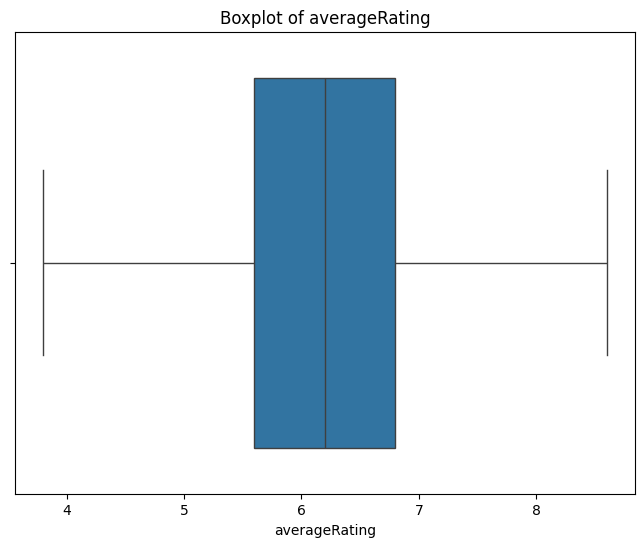

In [ ]:
# Function to generate a boxplot for the 'averageRating' column
def averageRating_boxplot(df):
      # Convert the 'averageRating' column from PySpark DataFrame to Pandas DataFrame
    pandas_df = df.select('averageRating').toPandas()

    # create boxplot
    plt.figure(figsize=(8, 6)) # Set the figure size for better visualization
    sns.boxplot(x=pandas_df['averageRating'])  # Create a boxplot of the 'averageRating' values
    plt.title('Boxplot of averageRating')  # Set the title for the plot
    plt.show() # Display the plot

# Call the function to generate the boxplot for 'averageRating'
averageRating_boxplot(df)

In [ ]:
df.count()

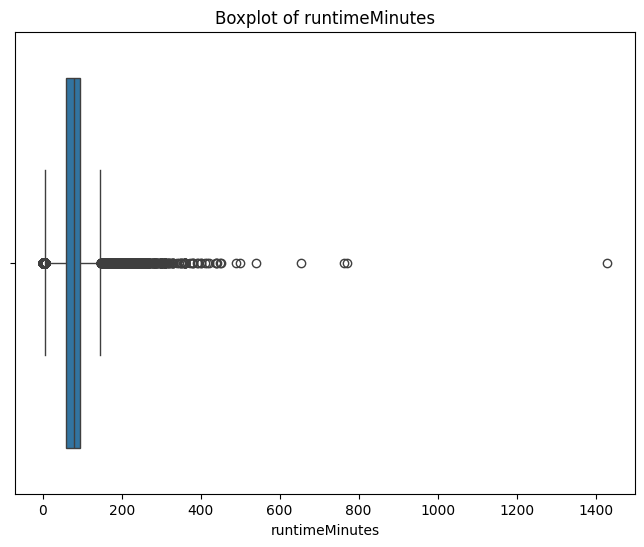

In [ ]:
# Function to generate a boxplot for the 'runtimeMinutes' column
def runtimeMinutes_boxplot(df):
      # Convert the 'runtimeMinutes' column from PySpark DataFrame to Pandas DataFrame
    pandas_df = df.select('runtimeMinutes').toPandas()

    # create boxplot
    plt.figure(figsize=(8, 6)) # Set the figure size for better visualization
    sns.boxplot(x=pandas_df['runtimeMinutes'])  # Create a boxplot of the 'runtimeMinutes' values
    plt.title('Boxplot of runtimeMinutes')  # Set the title for the plot
    plt.show() # Display the plot

# Call the function to generate the boxplot for 'runtimeMinutes'
runtimeMinutes_boxplot(df)

In [ ]:
# Function to calculate the first quartile (Q1), third quartile (Q3), and interquartile range (IQR) for a specified column
def calculate_Q1_Q3(df, column_name):

    # Calculate the first quartile (Q1) using approxQuantile function. 0.25 represents the 25th percentile (Q1)
    q1 = df.approxQuantile(column_name, [0.25], 0.0)[0]

    # Calculate the third quartile (Q3) using approxQuantile function. 0.75 represents the 75th percentile (Q3)
    q3 = df.approxQuantile(column_name, [0.75], 0.0)[0]

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1
    return q1, q3, iqr

# Calculate Q1, Q3, and IQR for the 'runtimeMinutes' column
q1, q3, iqr = calculate_Q1_Q3(df, 'runtimeMinutes')

# Calculate the lower and upper bounds for outlier detection based on IQR
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [ ]:
# Replace outlier values in the 'runtimeMinutes' column with the lower or upper bound
df = df.withColumn(
    "runtimeMinutes",  # Specify the column to be modified
    F.when(F.col("runtimeMinutes") < lower_bound, lower_bound)  # Replace values below the lower bound with the lower bound
     .when(F.col("runtimeMinutes") > upper_bound, upper_bound)  # Replace values above the upper bound with the upper bound
     .otherwise(F.col("runtimeMinutes"))  # Keep values within the bounds unchanged
)

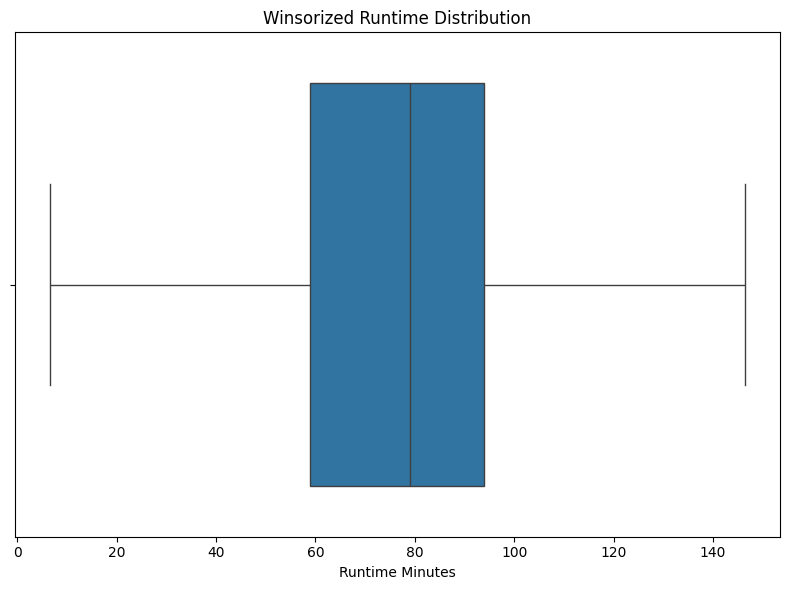

In [ ]:
# Convert 'runtimeMinutes' column to Pandas DataFrame
winsorized_df = df.select('runtimeMinutes').toPandas()

# Create a boxplot for the winsorized data
plt.figure(figsize=(8, 6))
sns.boxplot(x=winsorized_df['runtimeMinutes'])
plt.title('Winsorized Runtime Distribution')
plt.xlabel('Runtime Minutes')
plt.tight_layout()
plt.show()

In [ ]:
df.count()

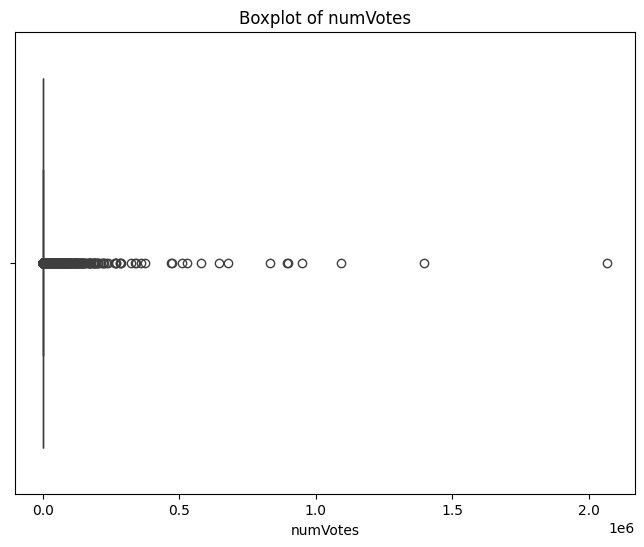

In [ ]:
pandas_df = df.select('numVotes').toPandas()

# Step 2: Create a boxplot for the 'numVotes' column
plt.figure(figsize=(8, 6))
sns.boxplot(x=pandas_df['numVotes'])

# Step 3: Show the plot
plt.title('Boxplot of numVotes')
plt.show()

In [ ]:
# Function to calculate the first quartile (Q1), third quartile (Q3), and interquartile range (IQR) for a specified column
def calculate_Q1_Q3(df, column_name):

    # Calculate the first quartile (Q1) using approxQuantile function. 0.25 represents the 25th percentile (Q1)
    q1 = df.approxQuantile(column_name, [0.25], 0.0)[0]

    # Calculate the third quartile (Q3) using approxQuantile function. 0.75 represents the 75th percentile (Q3)
    q3 = df.approxQuantile(column_name, [0.75], 0.0)[0]

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1
    return q1, q3, iqr

# Calculate Q1, Q3, and IQR for the 'numVotes' column
q1, q3, iqr = calculate_Q1_Q3(df, 'numVotes')

# Calculate the lower and upper bounds for outlier detection based on IQR
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [ ]:
# Apply the Winsorization technique to handle outliers in the 'numVotes' column
df = df.withColumn(
    "numVotes",  # Specify the column to be modified
    F.when(F.col("numVotes") < lower_bound, lower_bound)  # If 'numVotes' is less than the lower bound, set it to the lower bound
     .when(F.col("numVotes") > upper_bound, upper_bound)  # If 'numVotes' is greater than the upper bound, set it to the upper bound
     .otherwise(F.col("numVotes"))  # If 'numVotes' is within the bounds, keep the original value
)

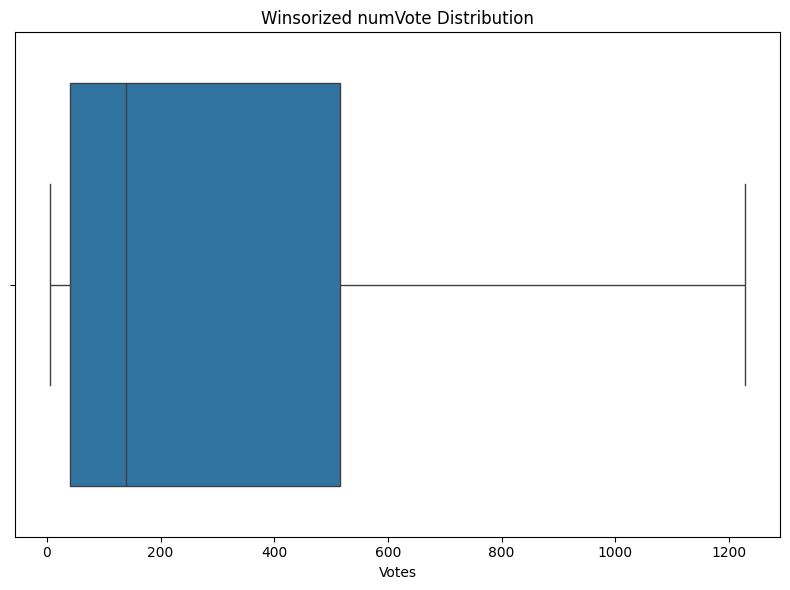

In [ ]:
pandas_df_winsorized = df.select('numVotes').toPandas()

# Step 4: Create a box plot for the winsorized data
plt.figure(figsize=(8, 6))
sns.boxplot(x=pandas_df_winsorized['numVotes'])
plt.title('Winsorized numVote Distribution')
plt.xlabel('Votes')
plt.tight_layout()
plt.show()

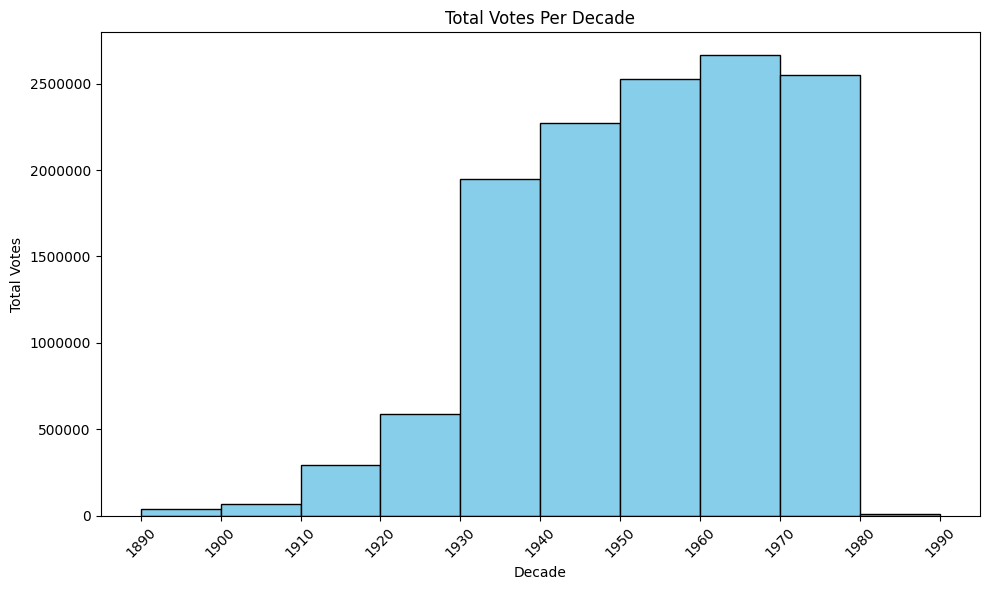

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def map_reduce_votes_by_decade(df):
    # Map: Extract (year, numVotes) pairs
    mapped = df.select('startYear', 'numVotes').rdd.map(lambda row: (row['startYear'], int(row['numVotes'])))

    # Reduce: Sum votes by year
    reduced = mapped.reduceByKey(lambda x, y: x + y)

    # Collect results
    reduced_data = reduced.collect()

    # Convert to dictionary
    result = dict(reduced_data)

    # Return the result
    return result

# Call the function with the DataFrame `df`
result = map_reduce_votes_by_decade(df)

# Prepare data for plotting
years = list(result.keys())
total_votes = list(result.values())

# Group years into decades
decades = [((year // 10) * 10) for year in years]
binned_votes = [total_votes[i] for i in range(len(years))]

# Create Histogram
plt.figure(figsize=(10, 6))
# Create bins for decades
plt.hist(decades, bins=np.arange(min(decades), max(decades) + 10, 10), weights=binned_votes, color='skyblue', edgecolor='black')
plt.title("Total Votes Per Decade")
plt.xlabel("Decade")
plt.ylabel("Total Votes")

# Turn off scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(np.arange(min(decades), max(decades) + 10, 10), rotation=45)
plt.tight_layout()
plt.show()

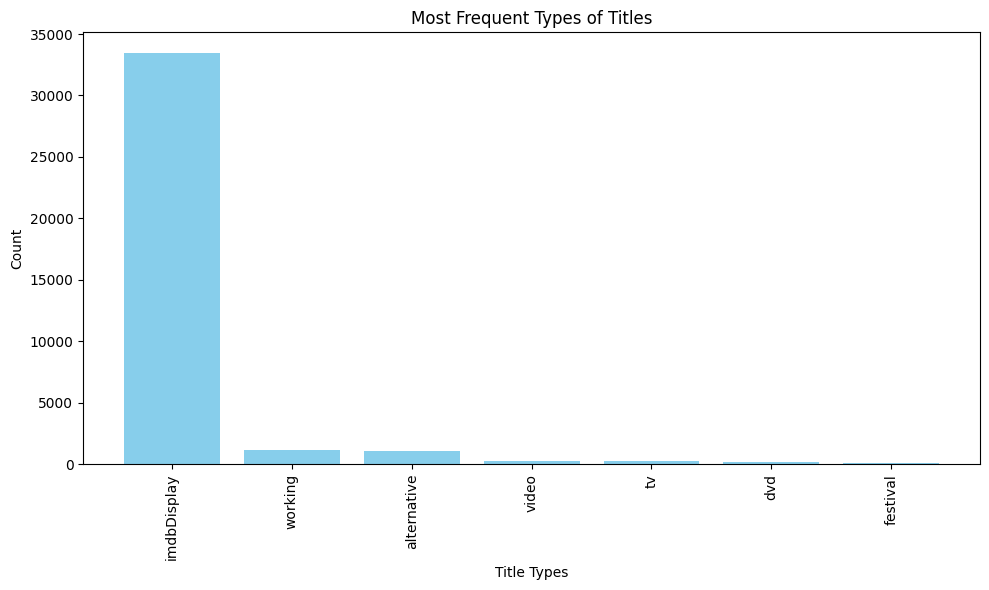

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Group by the 'types' column and count the occurrences of each type
types_count = df.groupBy("Types").count()

# Sort by count in descending order to get the most frequent types
types_count_sorted = types_count.orderBy(col("count").desc())

# Convert the result to Pandas for easier plotting
types_count_pd = types_count_sorted.toPandas()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(types_count_pd['Types'], types_count_pd['count'], color='skyblue')
plt.title("Most Frequent Types of Titles")
plt.xlabel("Title Types")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
from pyspark.sql import functions as F
# Function to analyze genre votes
def analyze_genre_votes(df):
    # Split the 'genres' column into individual rows and explode the array into rows
    df_genre_votes = df.select(F.explode(F.split(df["genres"], ",")).alias("genre"), "numVotes")

    # Group the data by genre and calculate total votes for each genre
    df_genre_votes_agg = df_genre_votes.groupBy("genre").agg(
        # Cast numVotes to integer and sum them for each genre
        F.sum(F.col("numVotes").cast("int")).alias("total_votes")
    )

    # Convert Spark DataFrame to Pandas DataFrame, orderBy sorts the genres by total votes in descending order before conversion
    df_genre_votes_pandas = df_genre_votes_agg.orderBy(F.desc("total_votes")).toPandas()

    return df_genre_votes_pandas

# Call the function 'analyze_genre_votes' to process the 'df' DataFrame,
df_genre_votes_pandas = analyze_genre_votes(df)

# Create a bar chart using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(df_genre_votes_pandas['genre'], df_genre_votes_pandas['total_votes'], color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Total Vote Count')
plt.title('Total Vote Count per Genre')
plt.ticklabel_format(style='plain', axis='y') # Disable scientific notation for y-axis
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.ylim(0, df_genre_votes_pandas['total_votes'].max() * 1.1)
plt.tight_layout() # Adjust layout
plt.show() # Show the plot

In [ ]:
# Display the first few rows of the DataFrame 'df_genre_votes_agg'
df_genre_votes_agg = analyze_genre_votes(df)  # This calls the function and stores the result in 'df_genre_votes_agg'

# Now, you can use the .show() method to display the first few rows of the Spark DataFrame
df_genre_votes_agg.show()


In [ ]:
import seaborn as sns
df_title_rating = df.groupBy("titleType").agg(
    F.collect_list("averageRating").alias("ratings")
)

# Convert to Pandas DataFrame for visualization
df_title_rating_pandas = df_title_rating.toPandas()

# Flatten the DataFrame for seaborn plotting
# Create a new DataFrame where each row contains a 'titleType' and its corresponding rating
flat_data = {
    'titleType': [],
    'averageRating': []
}

for _, row in df_title_rating_pandas.iterrows():
    for rating in row['ratings']:
        flat_data['titleType'].append(row['titleType'])
        flat_data['averageRating'].append(rating)

df_flat = pd.DataFrame(flat_data)

#Create the violin plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(x='titleType', y='averageRating', data=df_flat, palette='Set2')
plt.title('Distribution of Ratings by Title Type')
plt.tight_layout()
plt.show()

In [ ]:
df.show()

In [ ]:
df.count()

In [ ]:
df_title_rating.show()

In [ ]:
df_pandas = df.toPandas()

plt.figure(figsize=(12, 6))
sns.histplot(df_pandas['runtimeMinutes'], bins=20,  color='blue')
plt.title("Distribution of Movie Runtimes in Minutes")
plt.xlabel("Runtime (Minutes)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
from pyspark.sql.functions import mean

#Calculate the average votes for each titleType
avg_votes_by_title_type = df.groupBy('titleType').agg(
    mean('numVotes').alias('avg_votes')
)

# Convert the Spark DataFrame to Pandas DataFrame
avg_votes_by_title_type_pd = avg_votes_by_title_type.toPandas()

# Plot a Pie Chart of the average votes for each titleType
plt.figure(figsize=(8, 8))
plt.pie(
    avg_votes_by_title_type_pd['avg_votes'],
    labels=avg_votes_by_title_type_pd['titleType'],
    autopct='%1.1f%%',  # Display percentage on each slice
    startangle=90,  # Start the first slice at 90 degrees
    colors=sns.color_palette("muted", len(avg_votes_by_title_type_pd))  # Color palette
)
plt.title("Distribution of Average Votes by Title Type", fontsize=16)
plt.show()

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame
df_pandas = df.toPandas()

# Create a violin plot to show the variation of runtimeMinutes across each title type
plt.figure(figsize=(12, 5))
sns.violinplot(x='titleType', y='runtimeMinutes', data=df_pandas, palette='muted')
plt.title('Runtime Distribution by Title Type')
plt.xlabel('Title Type')
plt.ylabel('Runtime Minutes')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_selected = df.select('tconst', 'startYear', 'runtimeMinutes')
df_filtered = df_selected.limit(600)
json_output = 'Output_json.json'
df_filtered.write.json(json_output, mode='overwrite', compression='none')
print(f"Data successfully saved to {json_output}")

In [ ]:
from pyspark.sql import functions as F

def analyze_yearly_trends(df):
    # Group by start year and title type, Aggregate to count occurrences, Order the results
    yearly_trends = (df.groupBy("startYear", "titleType").agg(F.count("*").alias("count")).orderBy("startYear", "titleType"))
    return yearly_trends
result = analyze_yearly_trends(df)

# Convert to Pandas DataFrame for plotting
result_pd = result.toPandas()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=result_pd, x="startYear", y="count", hue="titleType", marker="o")
plt.title('Variation of Title type over the years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Title Count', fontsize=14)
plt.legend(title='Title Type', loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
from pyspark.sql import functions as F

def analyze_roles(df):
    # Group by 'category' and count distinct 'nconst' for each role
    role_counts = (df.groupBy("category")
        .agg(F.countDistinct("nconst").alias("crew_member_count"))  # Count distinct crew members
        .orderBy("crew_member_count", ascending=False)  #Sort by count
    )
    return role_counts
role_counts_df = analyze_roles(df)

# Convert PySpark DataFrame to Pandas DataFrame for plotting
role_counts_pd = role_counts_df.toPandas()

#Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='crew_member_count', y='category', data=role_counts_pd, palette='viridis')
plt.title("Number of Crew Members per Role (Category)", fontsize=16)
plt.xlabel("Number of Crew Members", fontsize=12)
plt.ylabel("Role (Category)", fontsize=12)
plt.show()

In [ ]:
# Select the two columns and limit the rows
df_selected = df.select('titleType', 'startYear').limit(500)

# Convert to Pandas DataFrame
df_selected_pandas = df_selected.toPandas()

# Save as CSV in Colab
csv_output = '/content/output_data.csv'
df_selected_pandas.to_csv(csv_output, index=False)

# Download the CSV to your local machine
from google.colab import files
files.download(csv_output)  # This will download the file to your local machine

print("Data exported successfully to local machine.")